<a href="https://colab.research.google.com/github/Matt-Toland/ProgrammingAssignment2/blob/master/Dublin_Bike_Share.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [95]:
import pandas as pd
import numpy as np

bike_data = pd.read_csv('/content/gdrive/MyDrive/Bike Share/dublinbikes_20210401_20210701.csv', usecols=['STATION ID', 'TIME', 'NAME', 'BIKE STANDS',
       'AVAILABLE BIKE STANDS', 'AVAILABLE BIKES', 'ADDRESS',
       'LATITUDE', 'LONGITUDE'])
weather_data = pd.read_csv('/content/gdrive/MyDrive/Bike Share/hly1752.csv',header=12, skiprows=range(16, 140000),  usecols=['date', 'rain', 'temp'])

In [96]:
# Getting to know the bike station data

bike_data['TIME'] = pd.to_datetime(bike_data['TIME'])
bike_data = bike_data.sort_values('TIME')
print(bike_data.shape)
print(bike_data['TIME'].describe(datetime_is_numeric=True))
first_bike_timestamp = bike_data['TIME'].min()
last_bike_timestamp = bike_data['TIME'].max()
group = bike_data.groupby('STATION ID')['TIME']
print(bike_data.groupby('STATION ID').agg({'BIKE STANDS': 'max' , 'TIME': pd.Series.nunique}))
print(bike_data.columns)
print(bike_data[['BIKE STANDS','AVAILABLE BIKE STANDS','AVAILABLE BIKES']])

(2884576, 9)
count                          2884576
mean     2021-05-16 23:48:10.506581760
min                2021-04-01 00:00:03
25%      2021-04-24 00:03:47.749999872
50%                2021-05-16 23:27:32
75%                2021-06-08 23:31:17
max                2021-07-01 23:55:02
Name: TIME, dtype: object
            BIKE STANDS   TIME
STATION ID                    
2                    20  26464
3                    20  26464
4                    20  26464
5                    40  26464
6                    20  26464
...                 ...    ...
113                  40  26464
114                  40  26464
115                  30  26464
116                  30  26464
117                  40  26464

[109 rows x 2 columns]
Index(['STATION ID', 'TIME', 'NAME', 'BIKE STANDS', 'AVAILABLE BIKE STANDS',
       'AVAILABLE BIKES', 'ADDRESS', 'LATITUDE', 'LONGITUDE'],
      dtype='object')
         BIKE STANDS  AVAILABLE BIKE STANDS  AVAILABLE BIKES
0                 20                  

In [97]:
print('No. of unique timestamps: ', bike_data['TIME'].unique().shape[0], '\nNo. of Timestamps: ' ,bike_data['TIME'].shape[0])
print('% unique timestamps: ' ,bike_data['TIME'].unique().shape[0]/bike_data['TIME'].shape[0]*100, '%')
print('No. Times timestamps repeated: ' ,bike_data['TIME'].shape[0]/bike_data['TIME'].unique().shape[0])
print('No. of  Stations: ', bike_data['STATION ID'].nunique())

No. of unique timestamps:  26464 
No. of Timestamps:  2884576
% unique timestamps:  0.9174311926605505 %
No. Times timestamps repeated:  109.0
No. of  Stations:  109


In [98]:
# Getting to know the weather data

print(weather_data.columns)
weather_data['date'] = pd.to_datetime(weather_data['date'])
print(weather_data.shape)
print('First timestamp is: ', weather_data['date'].min())
print('Last timestamp is: ', weather_data['date'].max())
print('\nNo. of unique timestamps: ', weather_data['date'].unique().shape[0], '\nNo. of Timestamps: ' ,weather_data['date'].shape[0])


Index(['date', 'rain', 'temp'], dtype='object')
(19664, 3)
First timestamp is:  2019-08-04 17:00:00
Last timestamp is:  2021-11-01 00:00:00

No. of unique timestamps:  19664 
No. of Timestamps:  19664


In [99]:
# Only want timestamps within same time period as bike_data

weather_data = weather_data[(weather_data['date']>= pd.to_datetime(first_bike_timestamp)) & (weather_data['date'] <= pd.to_datetime(last_bike_timestamp))]

In [100]:
weather_data['date'] = pd.to_datetime(weather_data['date'])
weather_data = weather_data.sort_values('date')
print(weather_data.info())
print('\n No. of rows: ', weather_data.shape[0])
print('\n',weather_data['date'].describe(datetime_is_numeric=True))
print('\nFirst timestamp is: ', weather_data['date'].min())
print('Last timestamp is: ', weather_data['date'].max())
print('\nNo. of unique timestamps: ', weather_data['date'].unique().shape[0], '\nNo. of Timestamps: ' ,weather_data['date'].shape[0])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2207 entries, 14528 to 16734
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2207 non-null   datetime64[ns]
 1   rain    2207 non-null   float64       
 2   temp    2207 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 69.0 KB
None

 No. of rows:  2207

 count                             2207
mean     2021-05-16 23:59:59.999996160
min                2021-04-01 01:00:00
25%                2021-04-24 00:30:00
50%                2021-05-17 00:00:00
75%                2021-06-08 23:30:00
max                2021-07-01 23:00:00
Name: date, dtype: object

First timestamp is:  2021-04-01 01:00:00
Last timestamp is:  2021-07-01 23:00:00

No. of unique timestamps:  2207 
No. of Timestamps:  2207


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
# Setting the timestamps for both datasets as the index and creating a tolerance timedelta for merging 

bike_data.index = bike_data['TIME']
weather_data.index = weather_data['date']
tol = pd.Timedelta('1 hour')

In [102]:
# merging the datasets as a LEFT JOIN using the nearest timestamp within an hour tolerance

merge = pd.merge_asof(left=bike_data,right=weather_data,right_index=True,left_index=True,direction='nearest',tolerance=tol)

In [103]:
# checking the new dataframe to make sure the merge didn't introduce any missing values

print(merge.head(6))
print(merge.columns)
print('\nNo. of missing values overall: ', merge.isna().sum())
print('\n', merge.dtypes)

                     STATION ID                TIME  ... rain  temp
TIME                                                 ...           
2021-04-01 00:00:03           2 2021-04-01 00:00:03  ...  0.0   8.3
2021-04-01 00:00:03          27 2021-04-01 00:00:03  ...  0.0   8.3
2021-04-01 00:00:03          97 2021-04-01 00:00:03  ...  0.0   8.3
2021-04-01 00:00:03         109 2021-04-01 00:00:03  ...  0.0   8.3
2021-04-01 00:00:03          54 2021-04-01 00:00:03  ...  0.0   8.3
2021-04-01 00:00:03          65 2021-04-01 00:00:03  ...  0.0   8.3

[6 rows x 12 columns]
Index(['STATION ID', 'TIME', 'NAME', 'BIKE STANDS', 'AVAILABLE BIKE STANDS',
       'AVAILABLE BIKES', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'date', 'rain',
       'temp'],
      dtype='object')

No. of missing values overall:  STATION ID               0
TIME                     0
NAME                     0
BIKE STANDS              0
AVAILABLE BIKE STANDS    0
AVAILABLE BIKES          0
ADDRESS                  0
LATITUDE          

In [104]:
# s = merge.select_dtypes(include='object').columns
# print(s)
# s = s.delete([0,1,2,3])
# merge[s] = merge[s].astype("float")
# print(s)

# exploring temperatures
print("\nAverage temp. across the months included:\n", merge.groupby(merge['TIME'].dt.month)['temp'].mean())
print("\nHighest temp. across the months included:\n", merge.groupby(merge['TIME'].dt.month)['temp'].max())
print("\nLowest temp. across the months included:\n", merge.groupby(merge['TIME'].dt.month)['temp'].min())


Average temp. across the months included:
 TIME
4     7.221933
5     9.926015
6    14.846123
7    14.804167
Name: temp, dtype: float64

Highest temp. across the months included:
 TIME
4    16.7
5    22.1
6    24.4
7    19.8
Name: temp, dtype: float64

Lowest temp. across the months included:
 TIME
4   -2.8
5   -0.8
6    5.7
7    9.2
Name: temp, dtype: float64


In [105]:
# Set the timestamps as the index

merge = merge.set_index('TIME')
merge[merge.index.duplicated(keep=False)]

,STATION ID,NAME,BIKE STANDS,AVAILABLE BIKE STANDS,AVAILABLE BIKES,ADDRESS,LATITUDE,LONGITUDE,date,rain,temp
TIME,,,,,,,,,,,
2021-04-01 00:00:03,2,BLESSINGTON STREET,20,6,14,Blessington Street,53.356770,-6.268140,2021-04-01 01:00:00,0.0,8.3
2021-04-01 00:00:03,27,MOLESWORTH STREET,20,20,0,Molesworth Street,53.341290,-6.258117,2021-04-01 01:00:00,0.0,8.3
2021-04-01 00:00:03,97,KILMAINHAM GAOL,40,22,18,Kilmainham Gaol,53.342113,-6.310015,2021-04-01 01:00:00,0.0,8.3
2021-04-01 00:00:03,109,BUCKINGHAM STREET LOWER,29,17,12,Buckingham Street Lower,53.353333,-6.249319,2021-04-01 01:00:00,0.0,8.3
2021-04-01 00:00:03,54,CLONMEL STREET,33,30,2,Clonmel Street,53.336021,-6.262980,2021-04-01 01:00:00,0.0,8.3
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01 23:55:02,31,PARNELL STREET,20,11,9,Parnell Street,53.350929,-6.265125,2021-07-01 23:00:00,0.0,14.4
2021-07-01 23:55:02,93,HEUSTON STATION (CENTRAL),40,20,20,Heuston Station (Central),53.346603,-6.296924,2021-07-01 23:00:00,0.0,14.4
2021-07-01 23:55:02,32,PEARSE STREET,30,23,7,Pearse Street,53.344303,-6.250427,2021-07-01 23:00:00,0.0,14.4


Try and work out total no. of dublin bikes in operation (sum of parked bikes across network at any one time)
- sum of available bikes acorss all stations for each given timestamp - PLOT this and the answer is max timestamp
- what are the most active hours of the day
- total no. of bikes - biks out of commission (for 24 hours) = avialable bikes per timestamp
- how does available bikes per timestamp relate to the no. parked bikes per timestamp - then you can compare this to weather 
- On a rainy day do people make shorter journeys?
- hour by hour scatter hist

In [106]:
# Making assumption that the remainder after subtracting (available bikes + available stands) from No. Bike stands is the no. of bikes currently not in comission

merge['DECOMISSIONED'] = (merge['BIKE STANDS'] - (merge['AVAILABLE BIKE STANDS'] + merge['AVAILABLE BIKES']))
merge2 = merge.groupby(['TIME','STATION ID']).first().reset_index()
#merge2 = merge.resample('H').ffill().first().reset_index(drop=True)
print(merge2)



                       TIME  STATION ID  ...  temp  DECOMISSIONED
0       2021-04-01 00:00:03           2  ...   8.3              0
1       2021-04-01 00:00:03           3  ...   8.3              0
2       2021-04-01 00:00:03           4  ...   8.3              0
3       2021-04-01 00:00:03           5  ...   8.3              0
4       2021-04-01 00:00:03           6  ...   8.3              0
...                     ...         ...  ...   ...            ...
2884571 2021-07-01 23:55:02         113  ...  14.4              0
2884572 2021-07-01 23:55:02         114  ...  14.4              1
2884573 2021-07-01 23:55:02         115  ...  14.4              0
2884574 2021-07-01 23:55:02         116  ...  14.4              0
2884575 2021-07-01 23:55:02         117  ...  14.4              0

[2884576 rows x 13 columns]


In [107]:
# Creating a pivot table to show the no. of bikes available at each station at each timestamp
# Creating a pivot table to show the no. of bikes not in comission at each station at each timestamp

stationsAvailable = merge2.pivot(index='TIME', columns = 'STATION ID', values='AVAILABLE BIKES')
stationsDecomission = merge2.pivot(index='TIME', columns = 'STATION ID', values='DECOMISSIONED')
print(stationsAvailable)
print(stationsDecomission)

# Calculating the sum for each of the above across all stations (total no. available and total no. decomissioned across entire station network)

available_bikes = stationsAvailable.sum(axis=1).reset_index()
decomissioned = stationsDecomission.sum(axis=1).reset_index()
available_bikes.columns = ['TIME','AVAILABLE BIKES']
decomissioned.columns = ['TIME','DECOMISSIONED BIKES']
print(available_bikes)
print(decomissioned)

STATION ID           2    3    4    5    6    7    ...  112  113  114  115  116  117
TIME                                               ...                              
2021-04-01 00:00:03   14    8    6   10    0    5  ...   25    5    7   26    7    8
2021-04-01 00:05:03   14    8    6   10    0    5  ...   25    5    7   26    7    8
2021-04-01 00:10:03   14    8    6   10    0    5  ...   25    5    7   26    7    8
2021-04-01 00:15:02   14    8    6   10    0    5  ...   25    5    7   26    7    8
2021-04-01 00:20:03   14    8    6   10    0    5  ...   25    5    7   26    7    8
...                  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
2021-07-01 23:35:02   19   12   14   31    5    3  ...   30   12    4   26   14    6
2021-07-01 23:40:02   19   13   14   31    5    3  ...   30   12    4   26   14    6
2021-07-01 23:45:02   19   13   14   32    5    3  ...   30   12    4   26   14    6
2021-07-01 23:50:04   19   13   14   32    5    3  ...   30   12 

       AVAILABLE BIKES
count     26464.000000
mean       1291.076595
std          63.176708
min        1001.000000
25%        1251.000000
50%        1294.000000
75%        1338.000000
max        1419.000000
       DECOMISSIONED BIKES
count         26464.000000
mean             14.926353
std              14.757859
min               0.000000
25%               4.000000
50%               8.000000
75%              23.000000
max              92.000000


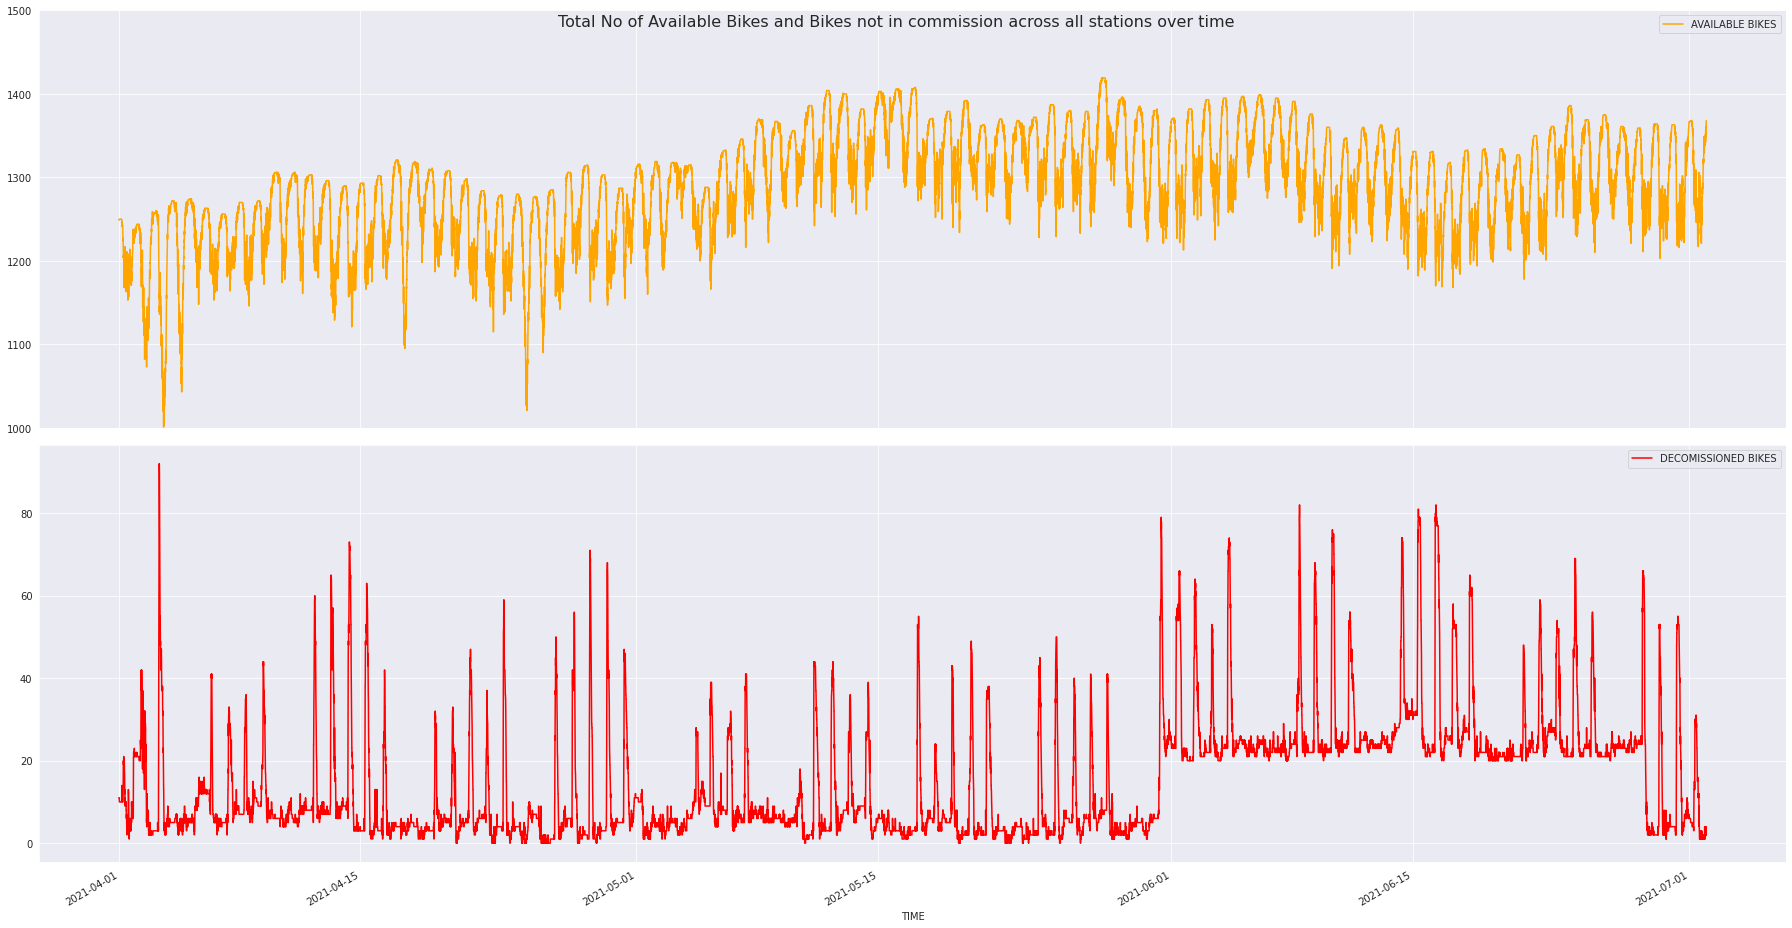

In [108]:
# Plotting the above across all the timestamps

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig.suptitle('Total No of Available Bikes and Bikes not in commission across all stations over time', fontsize=16)
ax1.set_ylim([1000,1500])
print(available_bikes.describe())
print(decomissioned.describe())

#active_bikes = active_bikes.resample('H').first()
available_bikes.plot('TIME','AVAILABLE BIKES', ax = ax1,color = 'orange')
decomissioned.plot('TIME', 'DECOMISSIONED BIKES', ax = ax2, color = 'red')
plt.show()




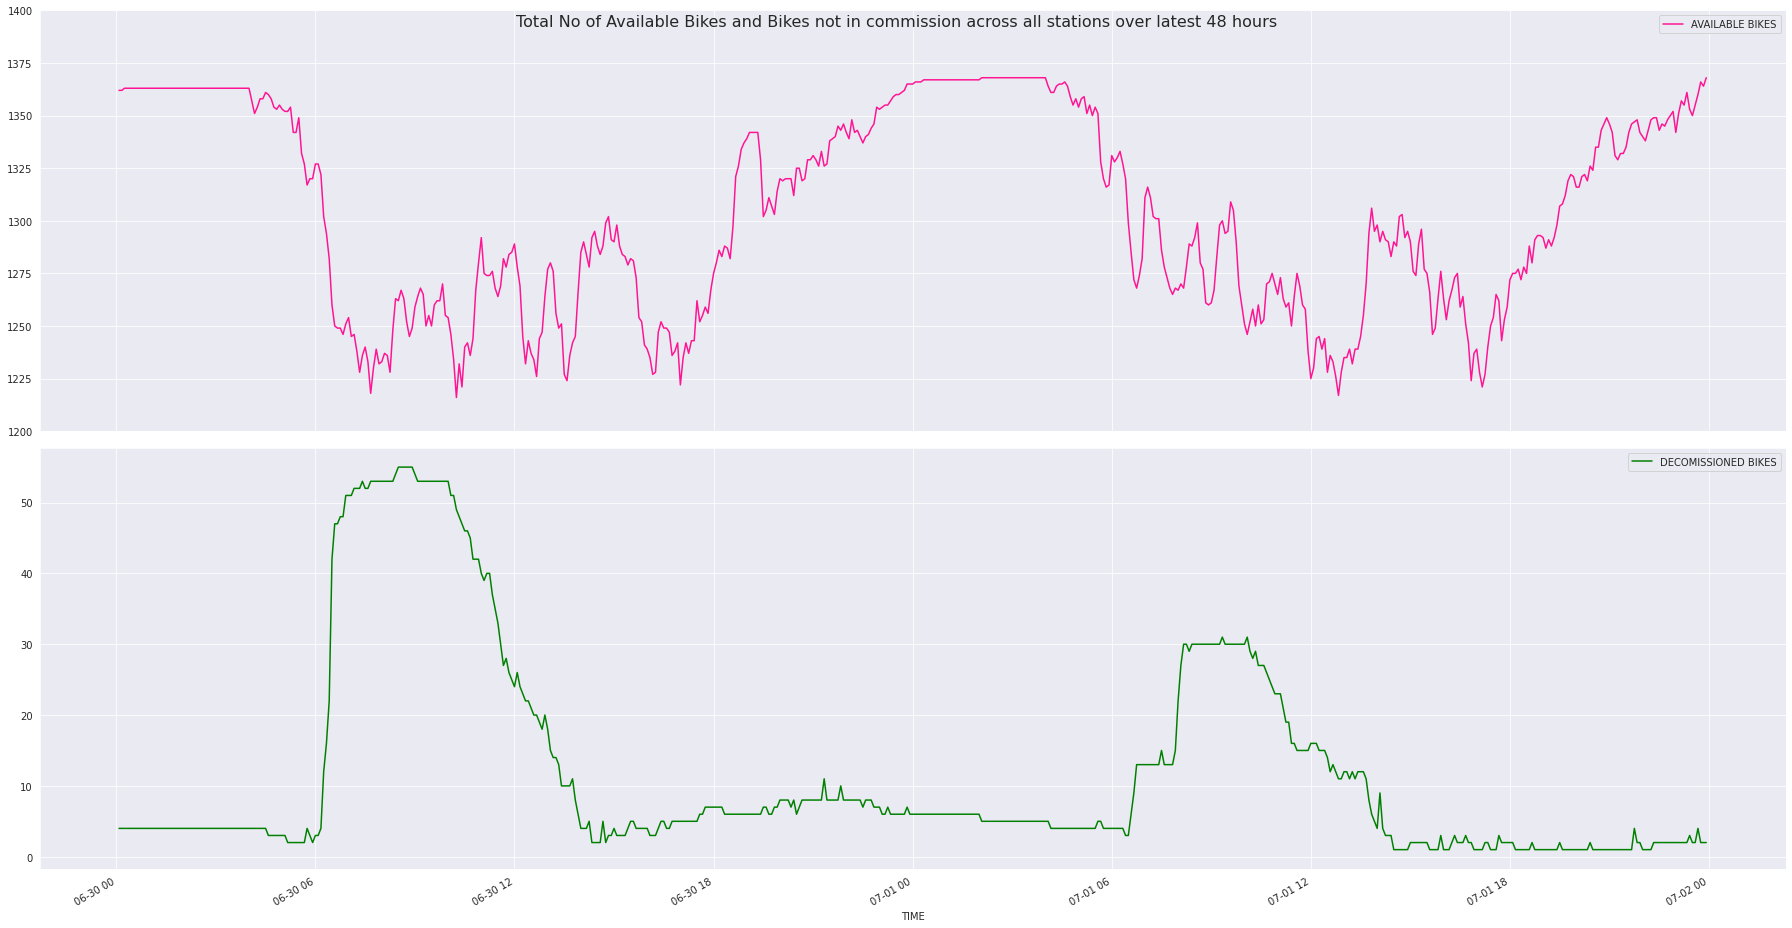

In [109]:
# Looking at the variability in available bikes across a dya
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig2, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig2.suptitle('Total No of Available Bikes and Bikes not in commission across all stations over latest 48 hours', fontsize=16)

available_bikes_day = available_bikes[available_bikes['TIME']>pd.to_datetime('2021-06-30 00:01:00')]
decomissioned_day = decomissioned[decomissioned['TIME']>pd.to_datetime('2021-06-30 00:01:00')]
ax1.set_ylim([1200,1400])

available_bikes_day.plot('TIME','AVAILABLE BIKES', ax = ax1,color = 'deeppink')
decomissioned_day.plot('TIME', 'DECOMISSIONED BIKES', ax = ax2, color = 'green')
plt.show()



Given the variability seen above, we will make the assumption that the total no. of available bikes in the network on any given day is the **max no. available across that 24 hour period** & likewise for the no. not in commission

In [110]:
#merge2['ALL AVAILABLE BIKES'] = merge2.set_index('TIME')['AVAILABLE BIKES'].resample('24 H').max()
print('The variability in max bikes available across every 24 hour window is: ' ,available_bikes.set_index('TIME')['AVAILABLE BIKES'].resample('24 H').max().describe())
max_available = available_bikes.set_index('TIME')['AVAILABLE BIKES'].resample('24 H').max()
max_available

The variability in max bikes available across every 24 hour window is:  count      92.000000
mean     1345.576087
std        44.544393
min      1250.000000
25%      1310.250000
50%      1359.500000
75%      1385.250000
max      1419.000000
Name: AVAILABLE BIKES, dtype: float64


TIME
2021-04-01    1250
2021-04-02    1259
2021-04-03    1266
2021-04-04    1272
2021-04-05    1274
              ... 
2021-06-27    1361
2021-06-28    1364
2021-06-29    1364
2021-06-30    1365
2021-07-01    1368
Freq: 24H, Name: AVAILABLE BIKES, Length: 92, dtype: int64

In [111]:
merge2['DATE'] = pd.to_datetime(merge2['TIME'].dt.date)
merge2 = pd.merge_asof(left=merge2,right=max_available, right_index=True, left_on= 'DATE' )
#merge2.drop('DATE', inplace=True)
merge2.drop(columns=['DATE'], inplace=True)
merge2.rename(columns={'AVAILABLE BIKES_y': 'AVAILABLE BIKES MAX', 'AVAILABLE BIKES_x' : 'AVAILABLE BIKES AT STATION'}, inplace=True)
print(merge2.columns)

Index(['TIME', 'STATION ID', 'NAME', 'BIKE STANDS', 'AVAILABLE BIKE STANDS',
       'AVAILABLE BIKES AT STATION', 'ADDRESS', 'LATITUDE', 'LONGITUDE',
       'date', 'rain', 'temp', 'DECOMISSIONED', 'AVAILABLE BIKES MAX'],
      dtype='object')


In [112]:
print(merge2.tail(24*12*109+2))

                       TIME  STATION ID  ... DECOMISSIONED  AVAILABLE BIKES MAX
2853182 2021-06-30 23:55:02         116  ...             0                 1365
2853183 2021-06-30 23:55:02         117  ...             0                 1365
2853184 2021-07-01 00:00:02           2  ...             0                 1368
2853185 2021-07-01 00:00:02           3  ...             0                 1368
2853186 2021-07-01 00:00:02           4  ...             0                 1368
...                     ...         ...  ...           ...                  ...
2884571 2021-07-01 23:55:02         113  ...             0                 1368
2884572 2021-07-01 23:55:02         114  ...             1                 1368
2884573 2021-07-01 23:55:02         115  ...             0                 1368
2884574 2021-07-01 23:55:02         116  ...             0                 1368
2884575 2021-07-01 23:55:02         117  ...             0                 1368

[31394 rows x 14 columns]


In [113]:
merge2 = pd.merge_asof(left=merge2,right=available_bikes, right_on='TIME', left_on= 'TIME')
print(merge2)

                       TIME  STATION ID  ... AVAILABLE BIKES MAX  AVAILABLE BIKES
0       2021-04-01 00:00:03           2  ...                1250             1249
1       2021-04-01 00:00:03           3  ...                1250             1249
2       2021-04-01 00:00:03           4  ...                1250             1249
3       2021-04-01 00:00:03           5  ...                1250             1249
4       2021-04-01 00:00:03           6  ...                1250             1249
...                     ...         ...  ...                 ...              ...
2884571 2021-07-01 23:55:02         113  ...                1368             1368
2884572 2021-07-01 23:55:02         114  ...                1368             1368
2884573 2021-07-01 23:55:02         115  ...                1368             1368
2884574 2021-07-01 23:55:02         116  ...                1368             1368
2884575 2021-07-01 23:55:02         117  ...                1368             1368

[2884576 rows x

In [114]:
merge2['ACTIVE BIKES'] = merge2['AVAILABLE BIKES MAX'] - merge2['AVAILABLE BIKES']
print(merge2)

                       TIME  STATION ID  ... AVAILABLE BIKES  ACTIVE BIKES
0       2021-04-01 00:00:03           2  ...            1249             1
1       2021-04-01 00:00:03           3  ...            1249             1
2       2021-04-01 00:00:03           4  ...            1249             1
3       2021-04-01 00:00:03           5  ...            1249             1
4       2021-04-01 00:00:03           6  ...            1249             1
...                     ...         ...  ...             ...           ...
2884571 2021-07-01 23:55:02         113  ...            1368             0
2884572 2021-07-01 23:55:02         114  ...            1368             0
2884573 2021-07-01 23:55:02         115  ...            1368             0
2884574 2021-07-01 23:55:02         116  ...            1368             0
2884575 2021-07-01 23:55:02         117  ...            1368             0

[2884576 rows x 16 columns]


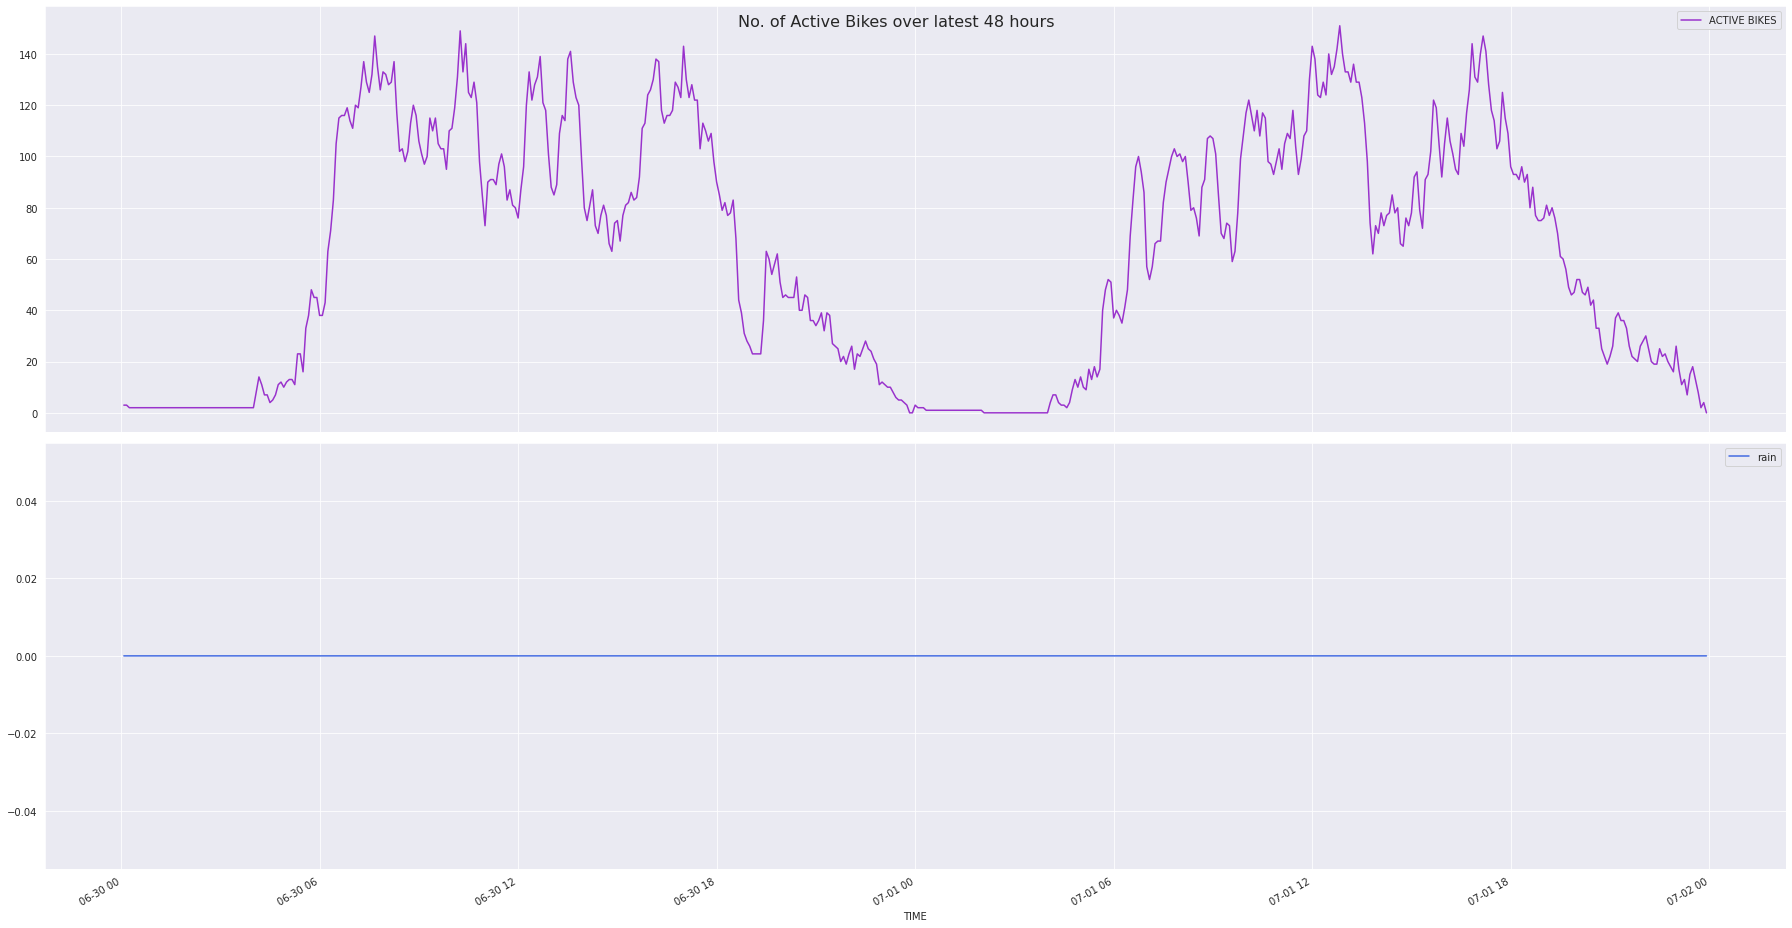

In [115]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig3, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig3.suptitle('No. of Active Bikes over latest 48 hours', fontsize=16)

last48hrs = merge2[merge2['TIME']>pd.to_datetime('2021-06-30 00:01:00')]

#ax1.set_ylim([1200,1400])

last48hrs.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
last48hrs.plot('TIME','rain', ax = ax2, color = 'royalblue')
plt.show()


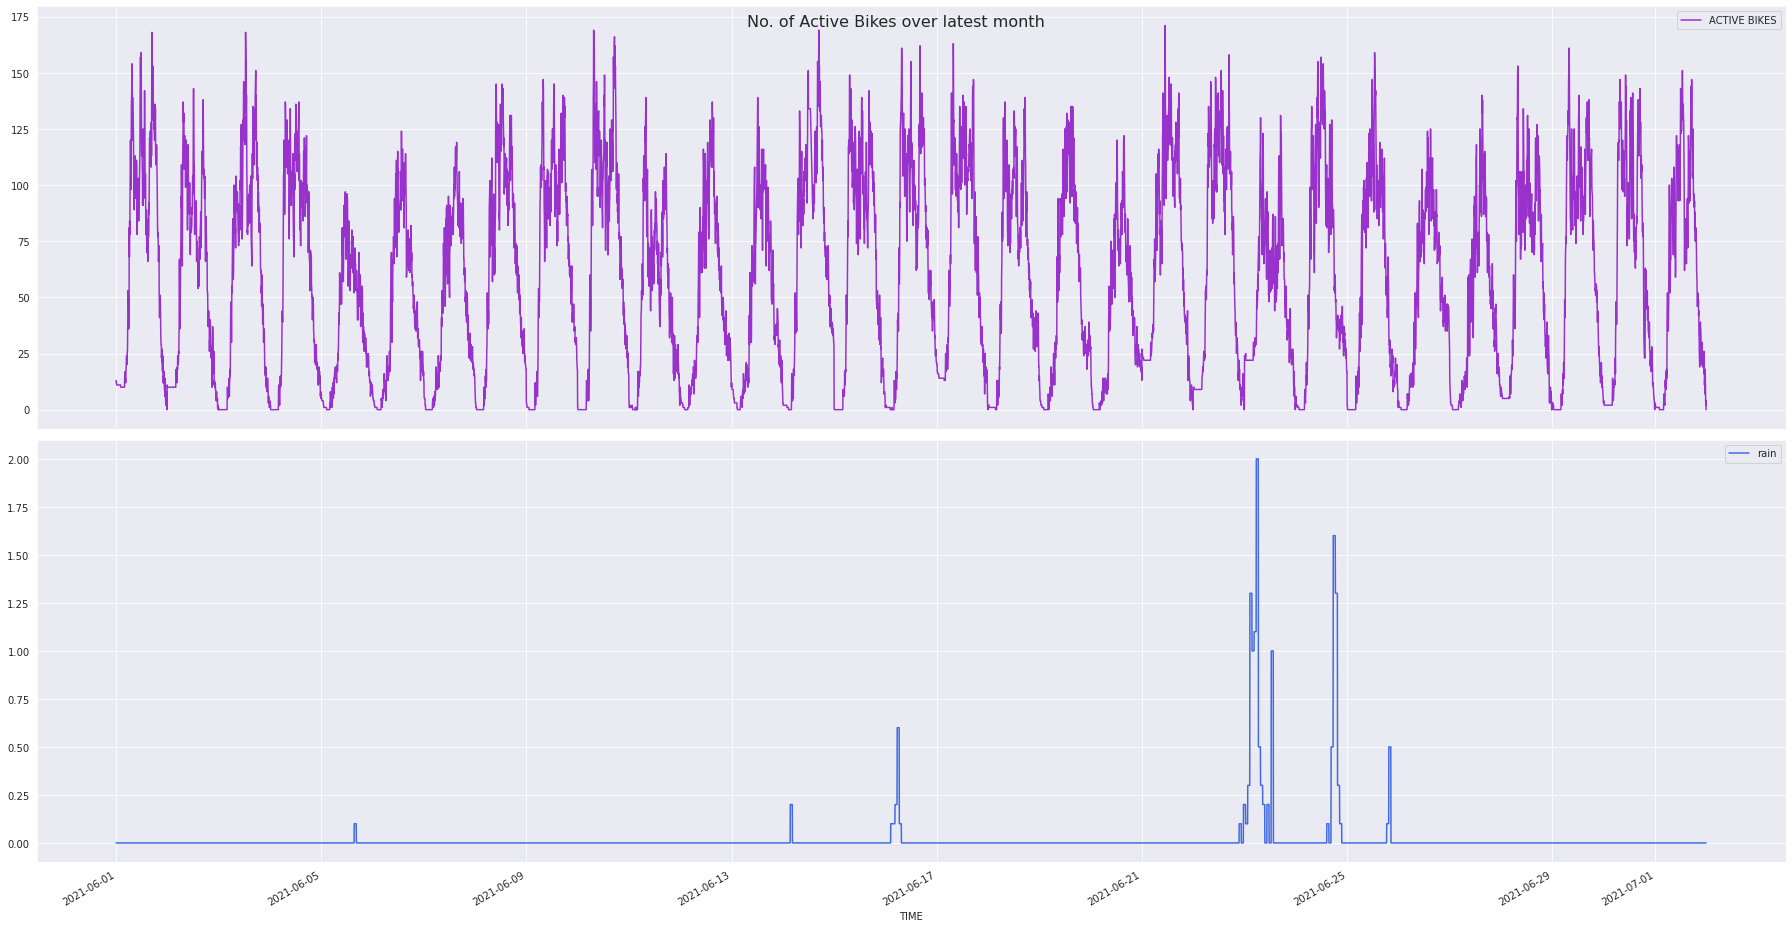

In [116]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig4, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig4.suptitle('No. of Active Bikes over latest month', fontsize=16)

lastmonth = merge2[merge2['TIME']>pd.to_datetime('2021-06-01 00:01:00')]

#ax1.set_ylim([1200,1400])

lastmonth.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
lastmonth.plot('TIME','rain', ax = ax2, color = 'royalblue')
plt.show()


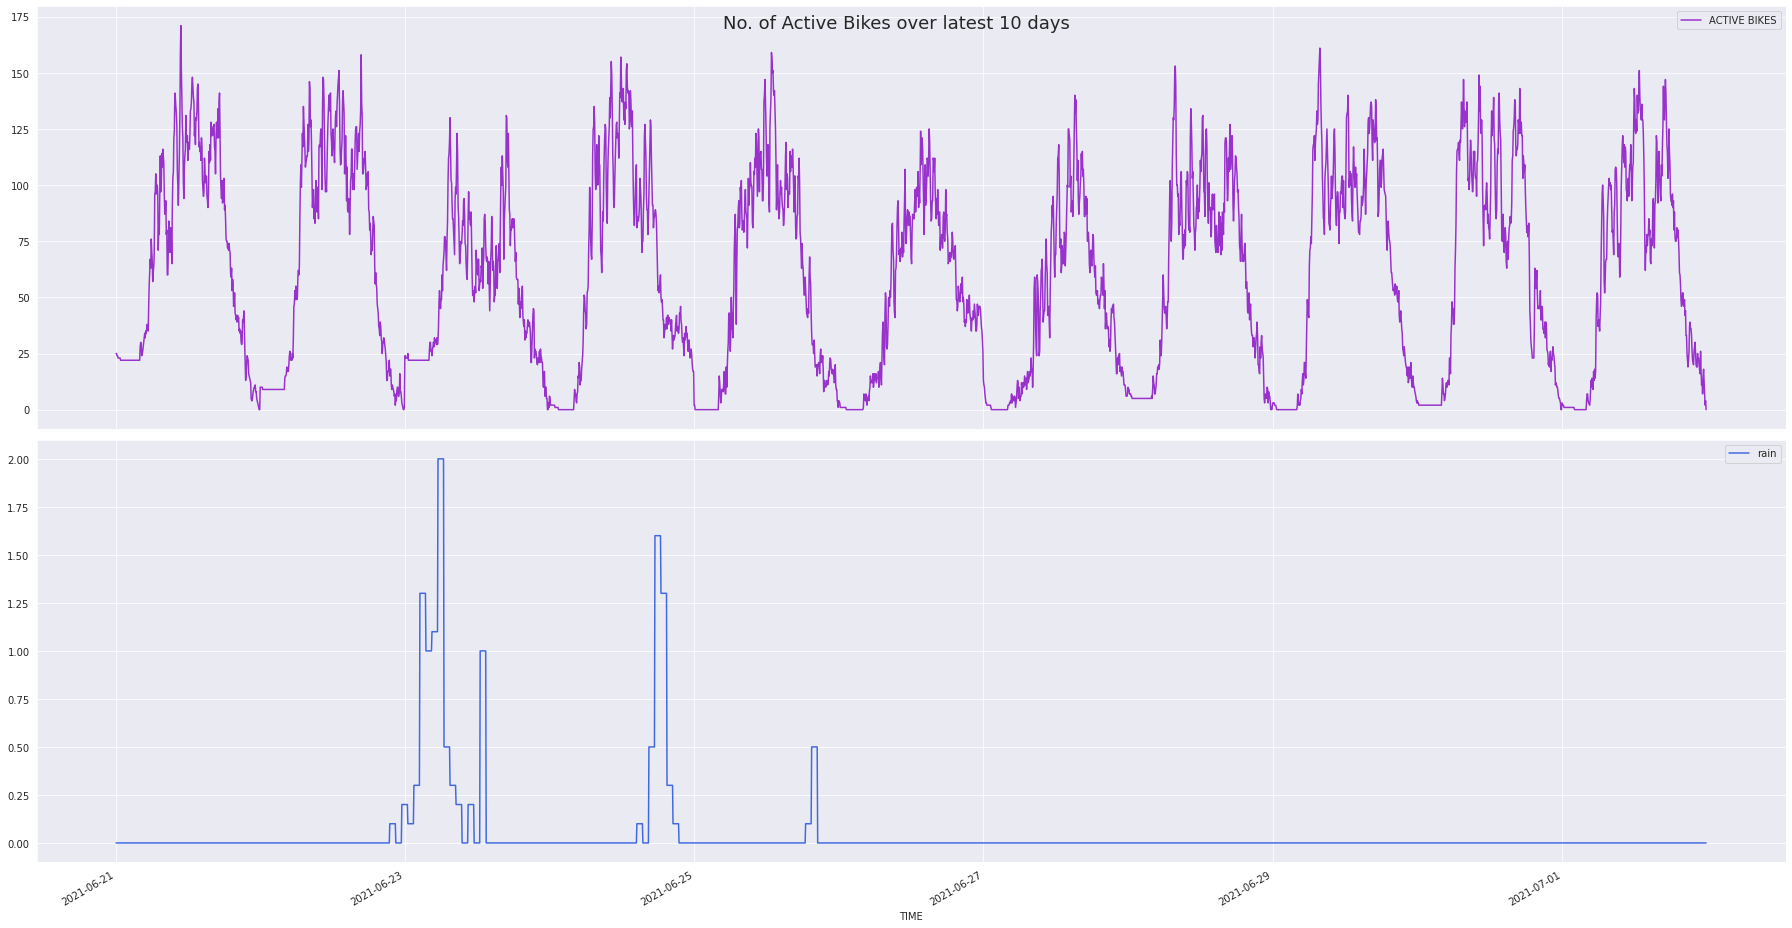

In [117]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig5, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig5.suptitle('No. of Active Bikes over latest 10 days', fontsize=18)

last10days = merge2[merge2['TIME']>pd.to_datetime('2021-06-21 00:01:00')]

#ax1.set_ylim([1200,1400])

last10days.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
last10days.plot('TIME','rain', ax = ax2, color = 'royalblue')
plt.show()


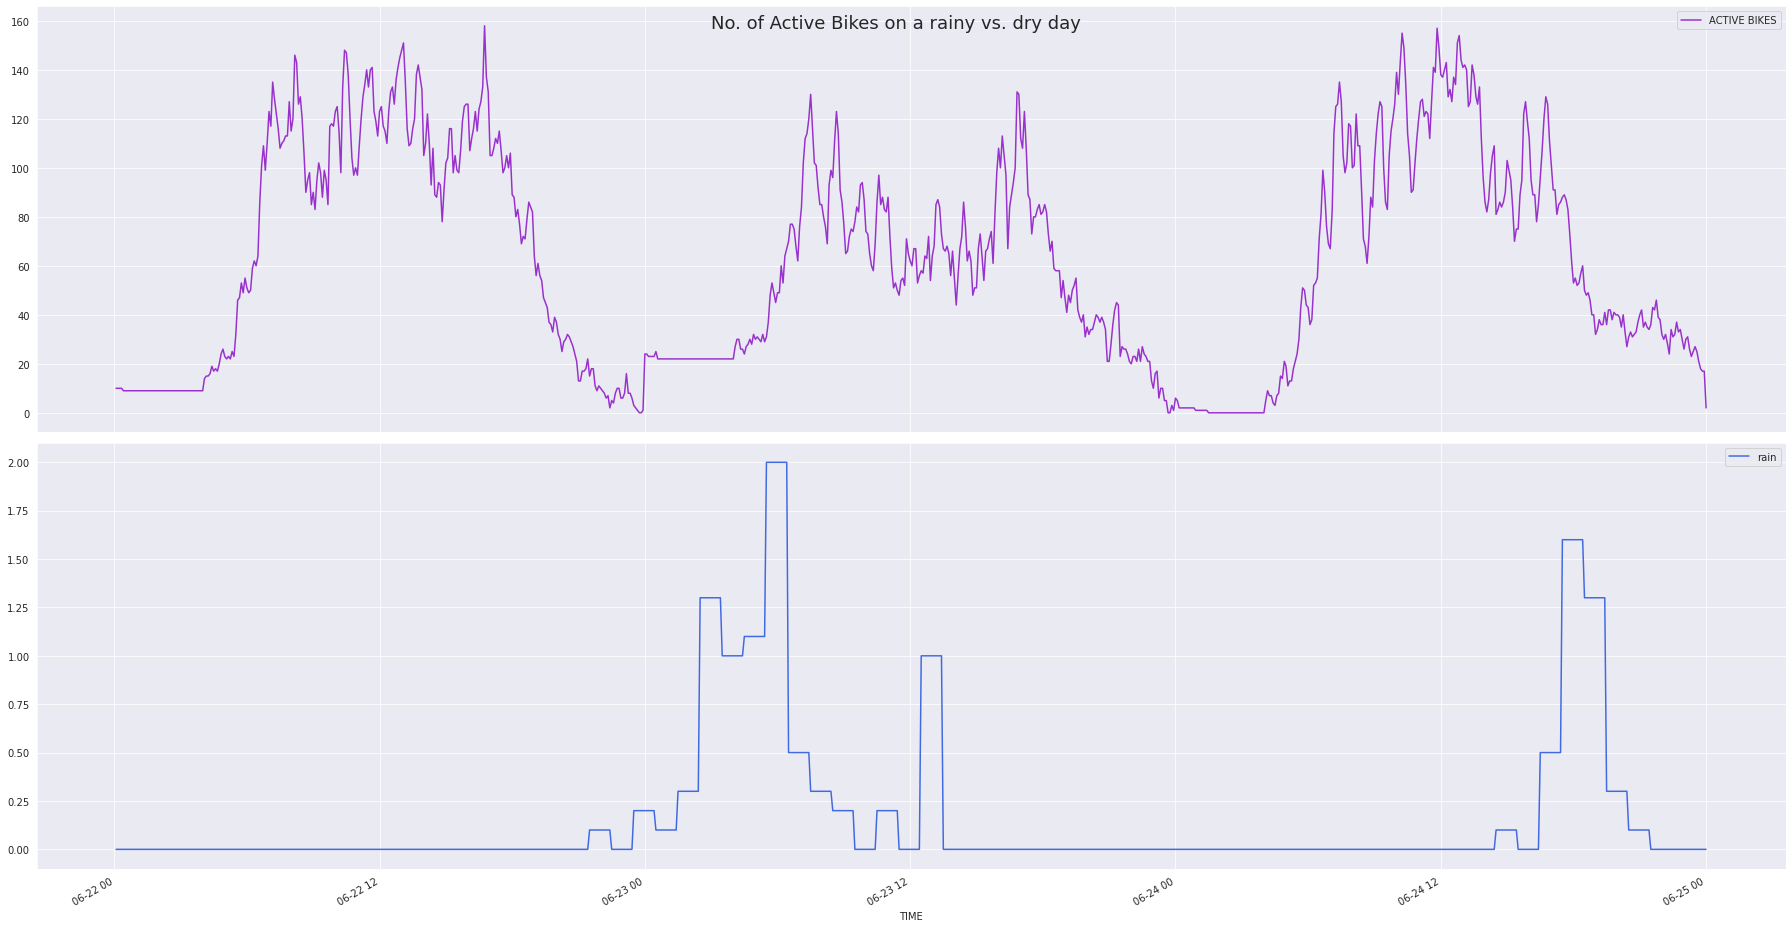

In [118]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig6, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig6.suptitle('No. of Active Bikes on a rainy vs. dry day', fontsize=18)

rainy_day = merge2[(merge2['TIME']>pd.to_datetime('2021-06-22 00:01:00')) & (merge2['TIME']<pd.to_datetime('2021-06-25 00:01:00'))]

#ax1.set_ylim([1200,1400])

rainy_day.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
rainy_day.plot('TIME','rain', ax = ax2, color = 'royalblue')
plt.show()


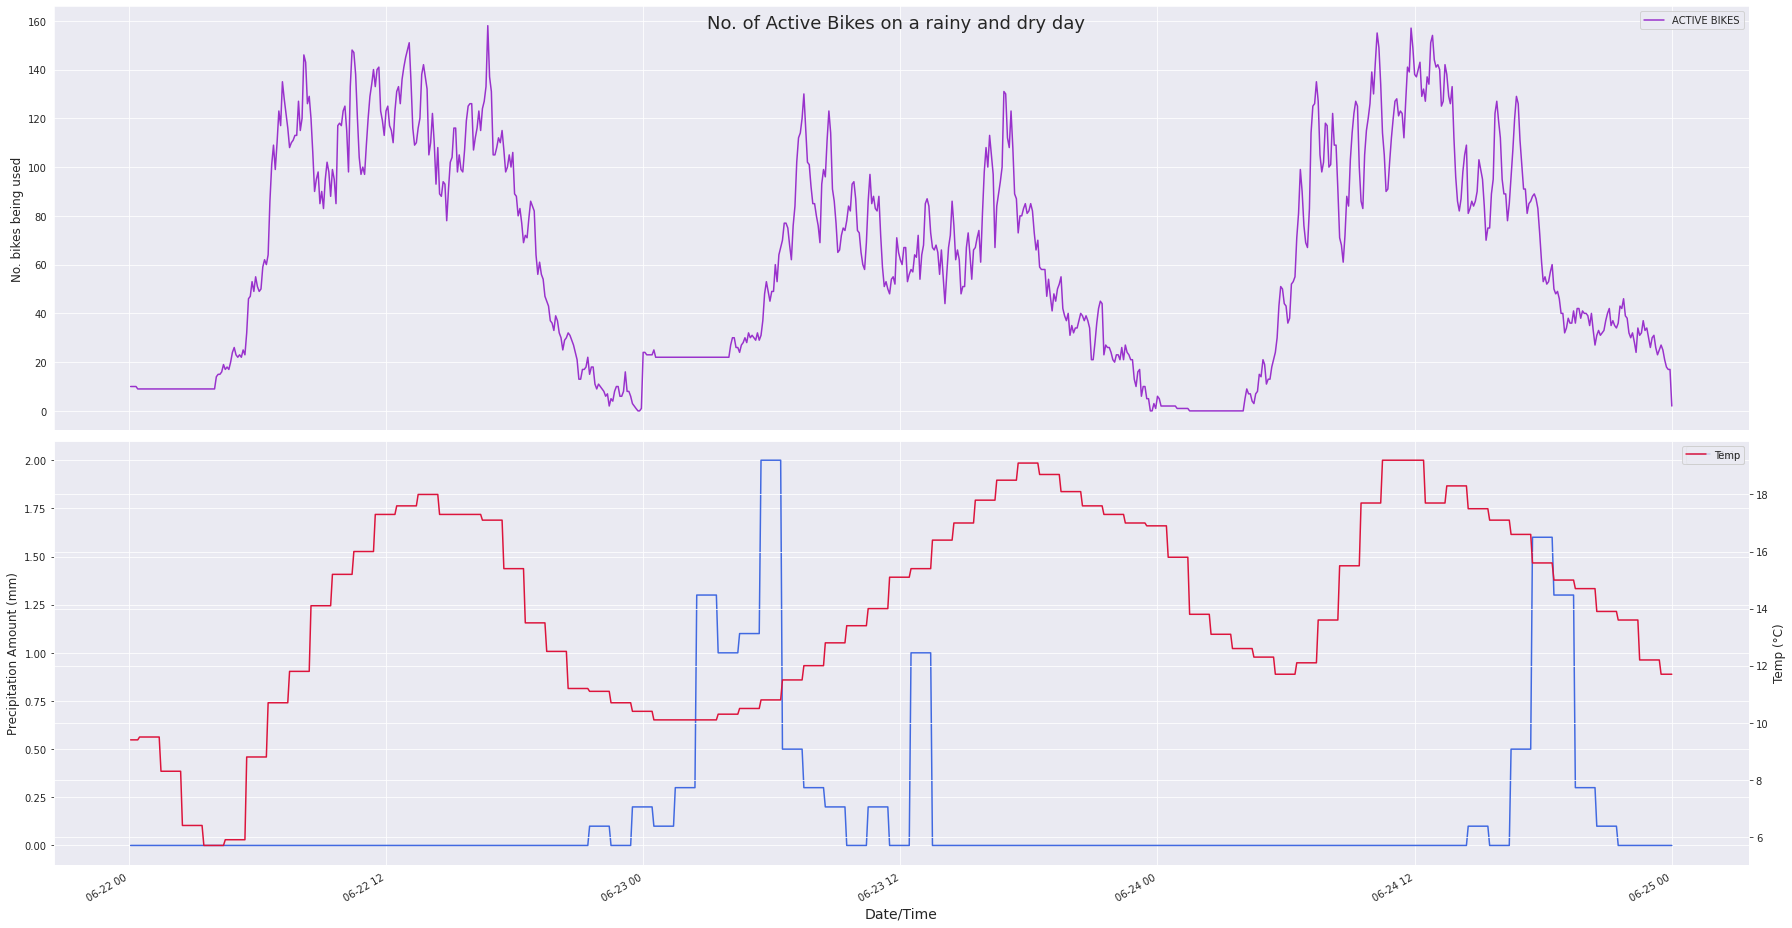

In [119]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig7, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig7.suptitle('No. of Active Bikes on a rainy and dry day', fontsize=18)

rainy_day = merge2[(merge2['TIME']>pd.to_datetime('2021-06-22 00:01:00')) & (merge2['TIME']<pd.to_datetime('2021-06-25 00:01:00'))]

#ax1.set_ylim([1200,1400])

rainy_day.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
rainy_day.plot('TIME','rain', ax = ax2, color = 'royalblue', label = 'Rain')
ax3 = ax2.twinx()
rainy_day.plot('TIME','temp', ax = ax3, color = 'crimson', label = 'Temp')

ax2.set_xlabel('Date/Time', fontsize = 14)
ax1.set_ylabel('No. bikes being used', fontsize = 12)
ax2.set_ylabel('Precipitation Amount (mm)', fontsize = 12)
ax3.set_ylabel('Temp (°C)', fontsize = 12)
plt.show()


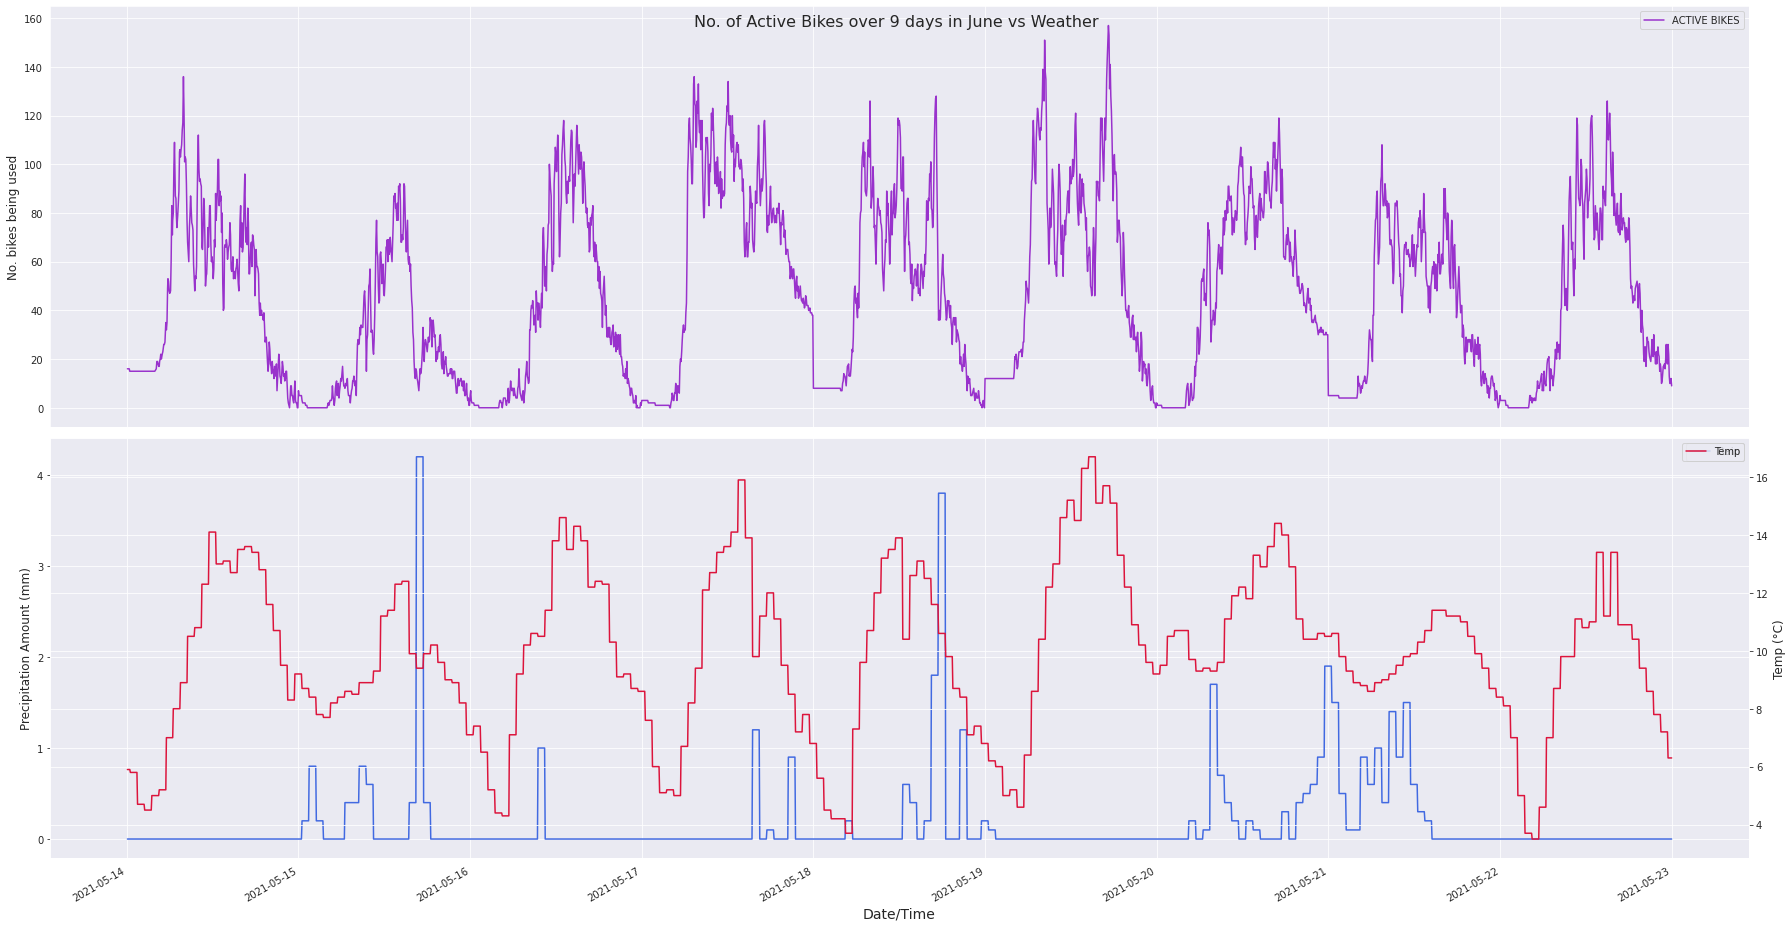

In [120]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig8, (ax1, ax2) = plt.subplots(2, figsize = (25,13), sharex = True, tight_layout = True)
fig8.suptitle('No. of Active Bikes over 9 days in June vs Weather', fontsize=16)

rainy_days_june = merge2[(merge2['TIME']>pd.to_datetime('2021-05-14 00:01:00')) & (merge2['TIME']<pd.to_datetime('2021-05-23 00:01:00'))]

#ax1.set_ylim([1200,1400])

rainy_days_june.plot('TIME','ACTIVE BIKES', ax = ax1, color = 'darkorchid')
rainy_days_june.plot('TIME','rain', ax = ax2, color = 'royalblue', label = 'Rain')
ax3 = ax2.twinx()
rainy_days_june.plot('TIME','temp', ax = ax3, color = 'crimson', label = 'Temp')

ax2.set_xlabel('Date/Time', fontsize = 14)
ax1.set_ylabel('No. bikes being used', fontsize = 12)
ax2.set_ylabel('Precipitation Amount (mm)', fontsize = 12)
ax3.set_ylabel('Temp (°C)', fontsize = 12)
plt.show()

In [121]:
print(merge2.columns)

Index(['TIME', 'STATION ID', 'NAME', 'BIKE STANDS', 'AVAILABLE BIKE STANDS',
       'AVAILABLE BIKES AT STATION', 'ADDRESS', 'LATITUDE', 'LONGITUDE',
       'date', 'rain', 'temp', 'DECOMISSIONED', 'AVAILABLE BIKES MAX',
       'AVAILABLE BIKES', 'ACTIVE BIKES'],
      dtype='object')


In [122]:
print(merge2['BIKE STANDS'].max())
print(merge2['BIKE STANDS'].min())
print(merge2['BIKE STANDS'].median())
print(merge2.columns)


40
16
30.0
Index(['TIME', 'STATION ID', 'NAME', 'BIKE STANDS', 'AVAILABLE BIKE STANDS',
       'AVAILABLE BIKES AT STATION', 'ADDRESS', 'LATITUDE', 'LONGITUDE',
       'date', 'rain', 'temp', 'DECOMISSIONED', 'AVAILABLE BIKES MAX',
       'AVAILABLE BIKES', 'ACTIVE BIKES'],
      dtype='object')


In [123]:
max_available_per_station24hr = merge2.groupby([merge2['TIME'].dt.date,'STATION ID'])['AVAILABLE BIKES AT STATION'].max()
max_available_per_station24hr = max_available_per_station24hr.reset_index()
max_available_per_station24hr['TIME'] = pd.to_datetime(max_available_per_station24hr['TIME'])
merge2['DATE'] = pd.to_datetime(merge2['TIME'].dt.date)

merge2 = pd.merge_asof(left=merge2,right=max_available_per_station24hr, right_on='TIME', left_on= 'DATE', by='STATION ID')

merge2.drop(columns=['DATE','TIME_y'], inplace=True)
merge2.rename(columns={'AVAILABLE BIKES AT STATION_x': 'AVAILABLE BIKES AT STATION', 'AVAILABLE BIKES AT STATION_y': 'AVAILABLE BIKES AT STATION MAX', 'TIME_x' : 'TIME'}, inplace=True)
print(merge2.columns)

Index(['TIME', 'STATION ID', 'NAME', 'BIKE STANDS', 'AVAILABLE BIKE STANDS',
       'AVAILABLE BIKES AT STATION', 'ADDRESS', 'LATITUDE', 'LONGITUDE',
       'date', 'rain', 'temp', 'DECOMISSIONED', 'AVAILABLE BIKES MAX',
       'AVAILABLE BIKES', 'ACTIVE BIKES', 'AVAILABLE BIKES AT STATION MAX'],
      dtype='object')


In [124]:
print(merge2[(merge2['TIME'].dt.date == pd.to_datetime('2021-04-01')) & (merge2['STATION ID'] == 3)])

                     TIME  ...  AVAILABLE BIKES AT STATION MAX
1     2021-04-01 00:00:03  ...                               8
110   2021-04-01 00:05:03  ...                               8
219   2021-04-01 00:10:03  ...                               8
328   2021-04-01 00:15:02  ...                               8
437   2021-04-01 00:20:03  ...                               8
...                   ...  ...                             ...
30848 2021-04-01 23:35:03  ...                               8
30957 2021-04-01 23:40:02  ...                               8
31066 2021-04-01 23:45:02  ...                               8
31175 2021-04-01 23:50:02  ...                               8
31284 2021-04-01 23:55:02  ...                               8

[288 rows x 17 columns]


In [125]:
# Creating a column to indicate the availability of bikes at each timestamp as a percentage of the maximum number avaialble during that day (as a percentage)

merge2['STATION AVAILABILITY'] = merge2['AVAILABLE BIKES AT STATION']/merge2['AVAILABLE BIKES AT STATION MAX']*100

In [126]:
print(merge2)

                       TIME  ...  STATION AVAILABILITY
0       2021-04-01 00:00:03  ...            100.000000
1       2021-04-01 00:00:03  ...            100.000000
2       2021-04-01 00:00:03  ...             66.666667
3       2021-04-01 00:00:03  ...             62.500000
4       2021-04-01 00:00:03  ...              0.000000
...                     ...  ...                   ...
2884571 2021-07-01 23:55:02  ...             52.173913
2884572 2021-07-01 23:55:02  ...             21.052632
2884573 2021-07-01 23:55:02  ...             96.296296
2884574 2021-07-01 23:55:02  ...             93.333333
2884575 2021-07-01 23:55:02  ...            100.000000

[2884576 rows x 18 columns]


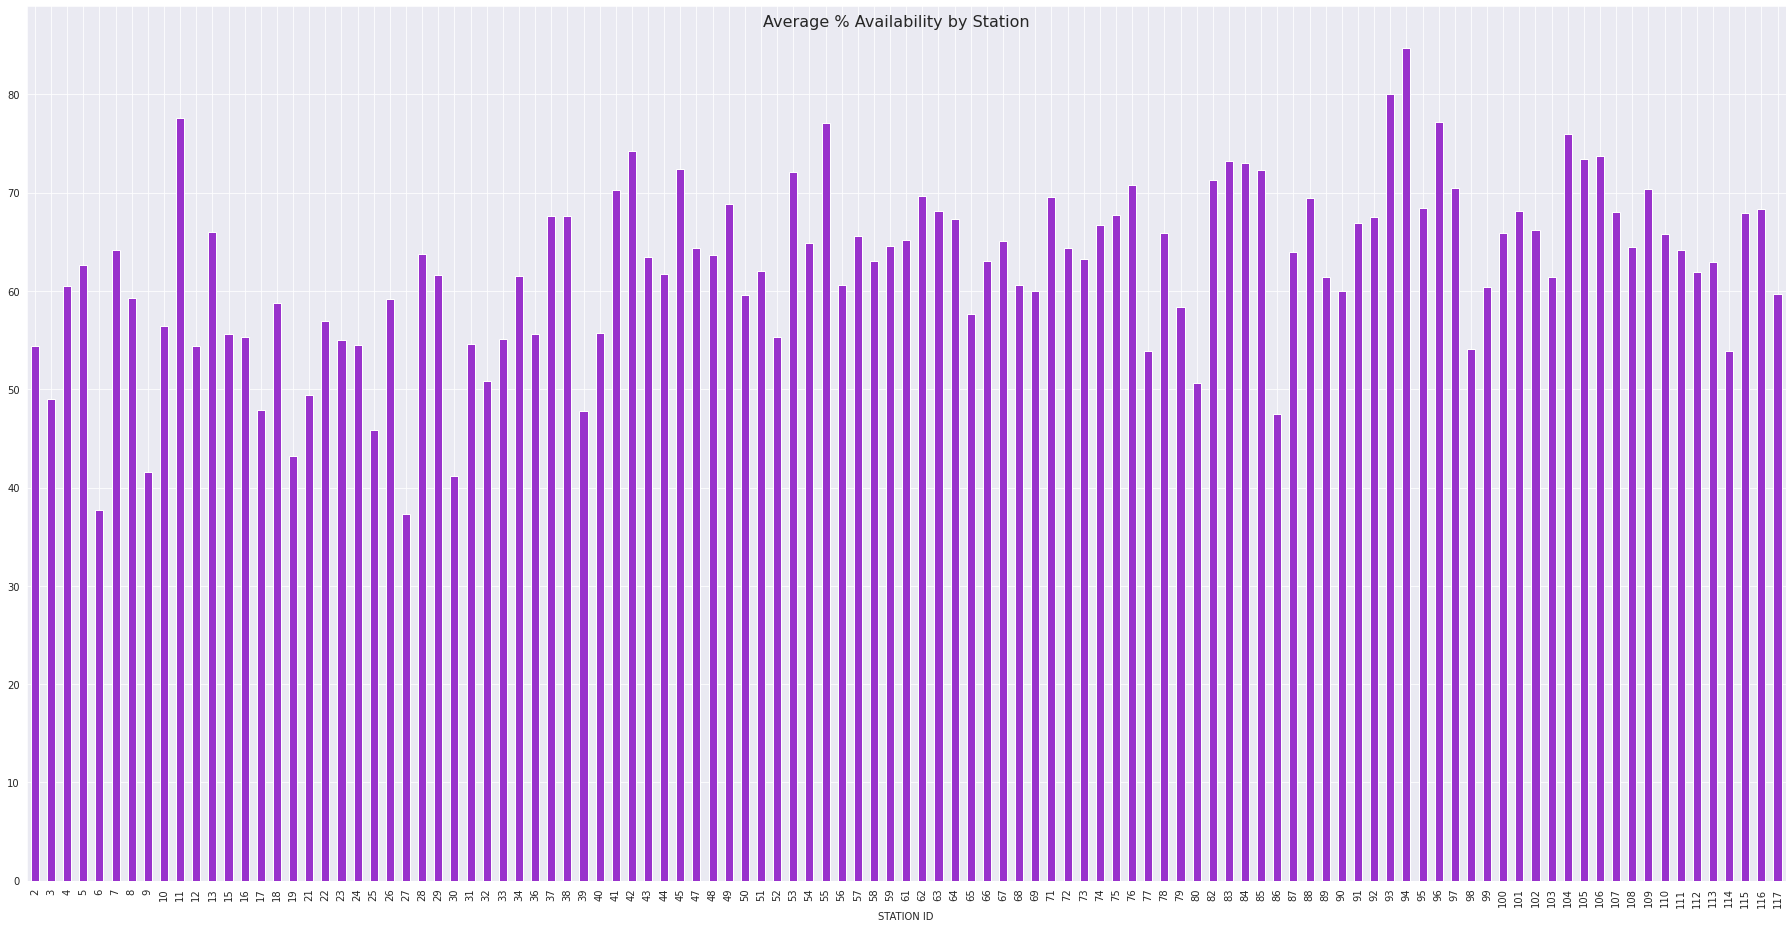

In [127]:
Avg_Station_Availability = merge2.groupby('STATION ID')['STATION AVAILABILITY'].mean()

sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks


fig3, ax = plt.subplots( figsize = (25,13), sharex = True, tight_layout = True)
fig3.suptitle('Average % Availability by Station', fontsize=16)

#ax1.set_ylim([1200,1400])

Avg_Station_Availability.plot.bar( ax = ax, color = 'darkorchid')
plt.show()


In [128]:
!pip install kneed
!pip install scikit-learn

In [129]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [130]:
ActivityByDay = merge2.groupby([merge2['TIME'].dt.day_name(),'TIME'])['ACTIVE BIKES'].mean()
ActivityByDay.index.names=['Day of Week','TIME']
print(ActivityByDay)

Day of Week  TIME               
Friday       2021-04-02 00:00:04    19
             2021-04-02 00:05:03    19
             2021-04-02 00:10:02    18
             2021-04-02 00:15:02    18
             2021-04-02 00:20:03    18
                                    ..
Wednesday    2021-06-30 23:35:03     5
             2021-06-30 23:40:03     4
             2021-06-30 23:45:03     3
             2021-06-30 23:50:02     0
             2021-06-30 23:55:02     0
Name: ACTIVE BIKES, Length: 26464, dtype: int64


In [131]:
Mon = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Monday'].droplevel(0))
Tue = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Tuesday'].droplevel(0))
Wed = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Wednesday'].droplevel(0))
Thu = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Thursday'].droplevel(0))
Fri = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Friday'].droplevel(0))
Sat = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Saturday'].droplevel(0))
Sun = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == 'Sunday'].droplevel(0))
print(Mon)

TIME
2021-04-05 00:00:03    3
2021-04-05 00:05:03    2
2021-04-05 00:10:03    1
2021-04-05 00:15:02    1
2021-04-05 00:20:02    1
                      ..
2021-06-28 23:35:02    4
2021-06-28 23:40:02    0
2021-06-28 23:45:02    1
2021-06-28 23:50:03    0
2021-06-28 23:55:02    1
Name: ACTIVE BIKES, Length: 3731, dtype: int64


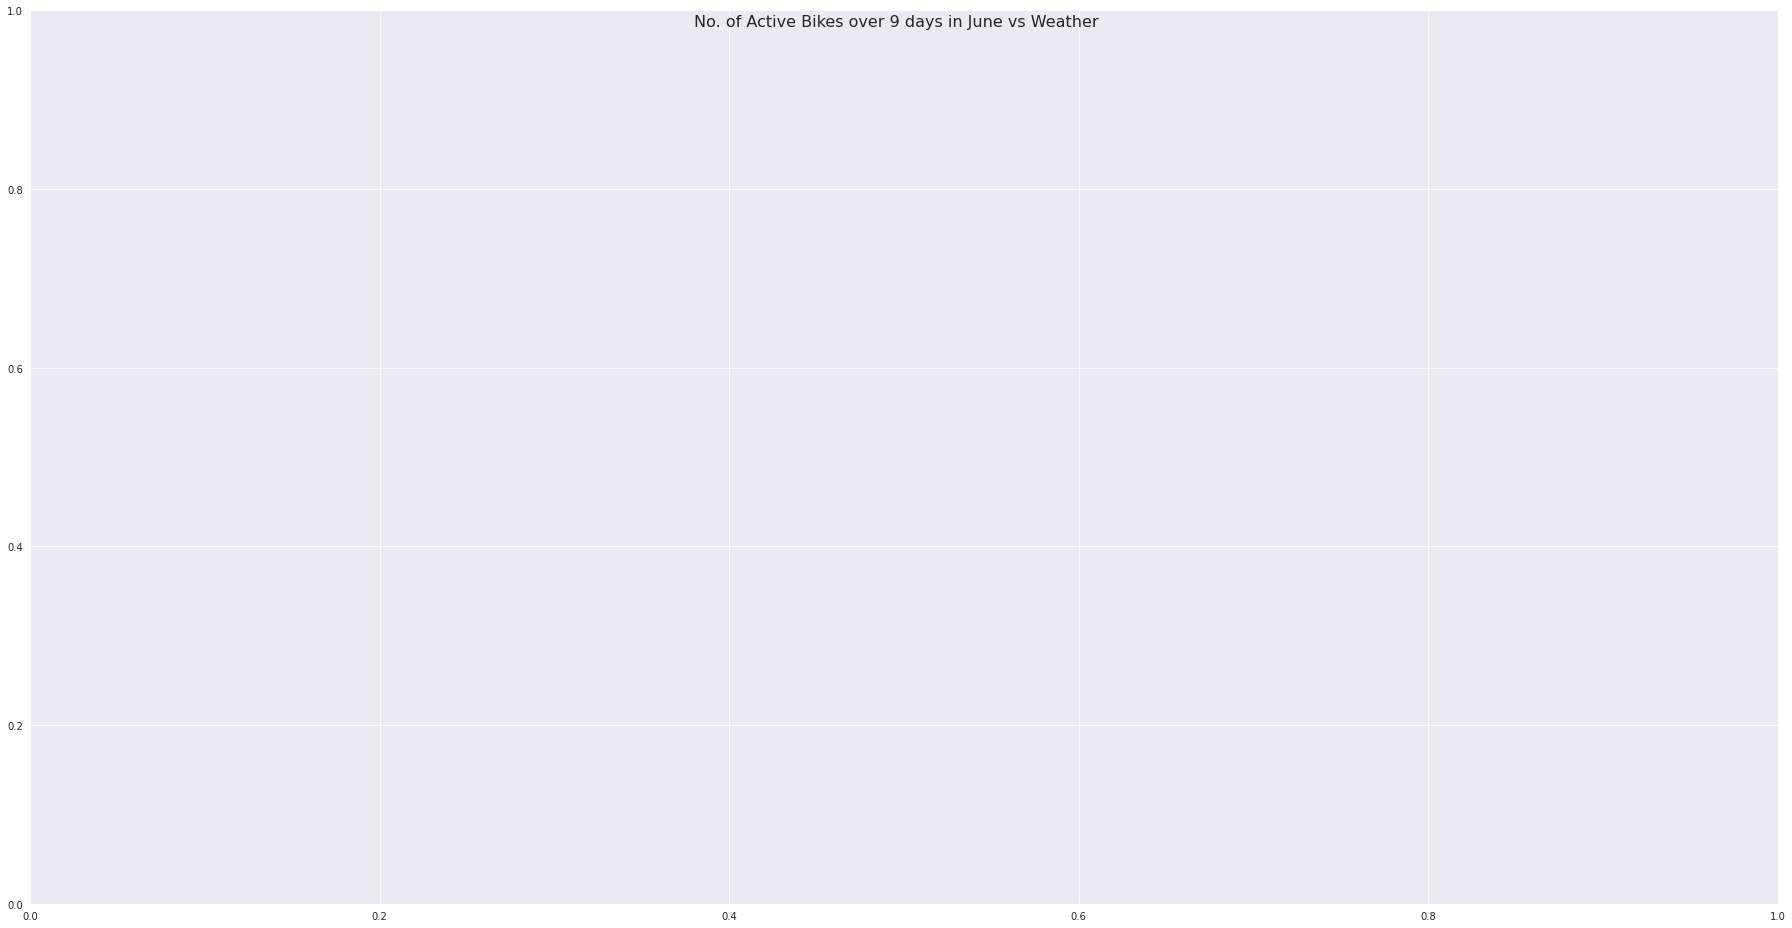

In [132]:
fig10,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig10.suptitle('No. of Active Bikes over 9 days in June vs Weather', fontsize=16)

Monday.plot( ax = ax1, color = 'darkorchid')

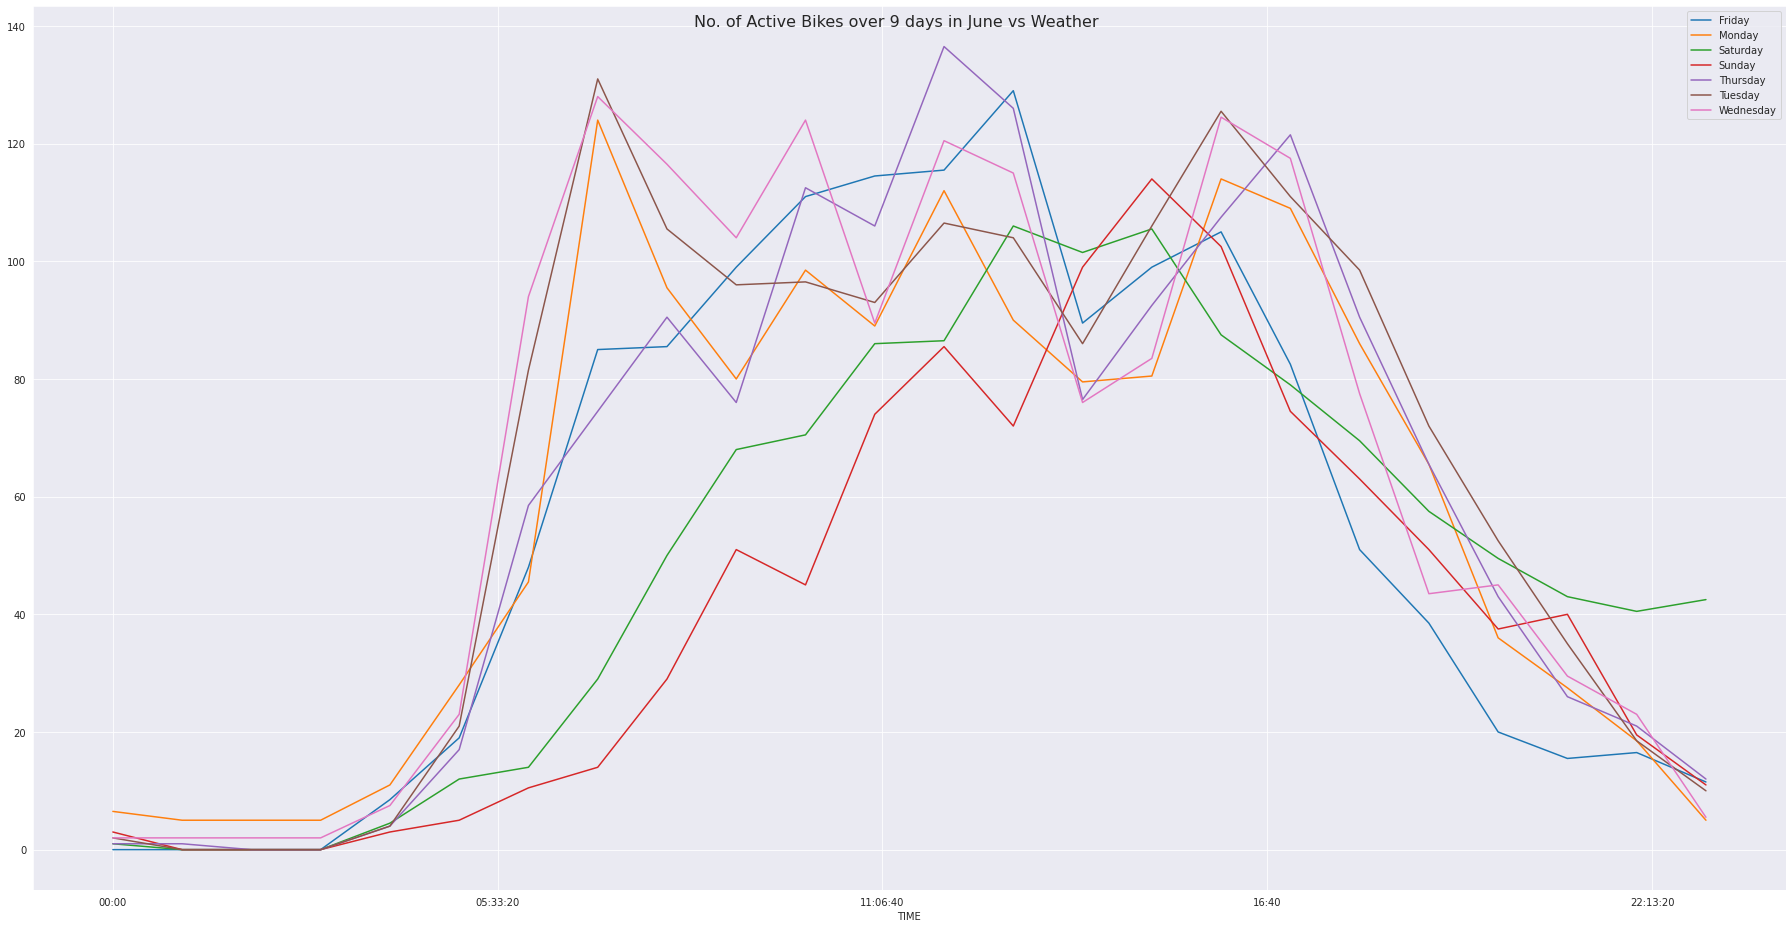

In [133]:
daysofweek = list(ActivityByDay.index.get_level_values(0).unique())
fig10,ax = plt.subplots(figsize = (25,13), sharex = True, tight_layout = True)
fig10.suptitle('No. of Active Bikes over 9 days in June vs Weather', fontsize=16)

for day in daysofweek:
  
  day = pd.Series(ActivityByDay.iloc[ActivityByDay.index.get_level_values('Day of Week') == day].droplevel(0),name=day)
  day = day.resample('1H').median()
  day = day.reset_index()
  day['date'] = day['TIME'].dt.date
  day['TIME'] = day['TIME'].dt.time
  day = day[day['date'] == day['date'].max()]
  day.plot(x= 'TIME', ax = ax)

